# TIME GAN 

# Implementation

In [75]:
# Import this apple stock price dataset and filter from 2015 to 2021
import pandas as pd
from data_loading import real_data_loading
import numpy as np


pd.set_option('display.max_columns', None)  
df = pd.read_csv('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset/stock_data.csv')
df.head()

,Open,High,Low,Close,Adj_Close,Volume
0,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,52.140873,53.651051,51.604362,52.657513,52.657513,9257400


In [76]:
import pandas as pd
from data_loading import real_data_loading
import numpy as np

## Data loading
data_name = 'stock'
seq_len = 24
n_seq = 6

if data_name in ['stock', 'energy']:
  ori_data = real_data_loading(data_name, seq_len)
print(data_name + ' dataset is ready.')

print(np.array(ori_data).shape)

data = ori_data

stock dataset is ready.
(3661, 24, 6)


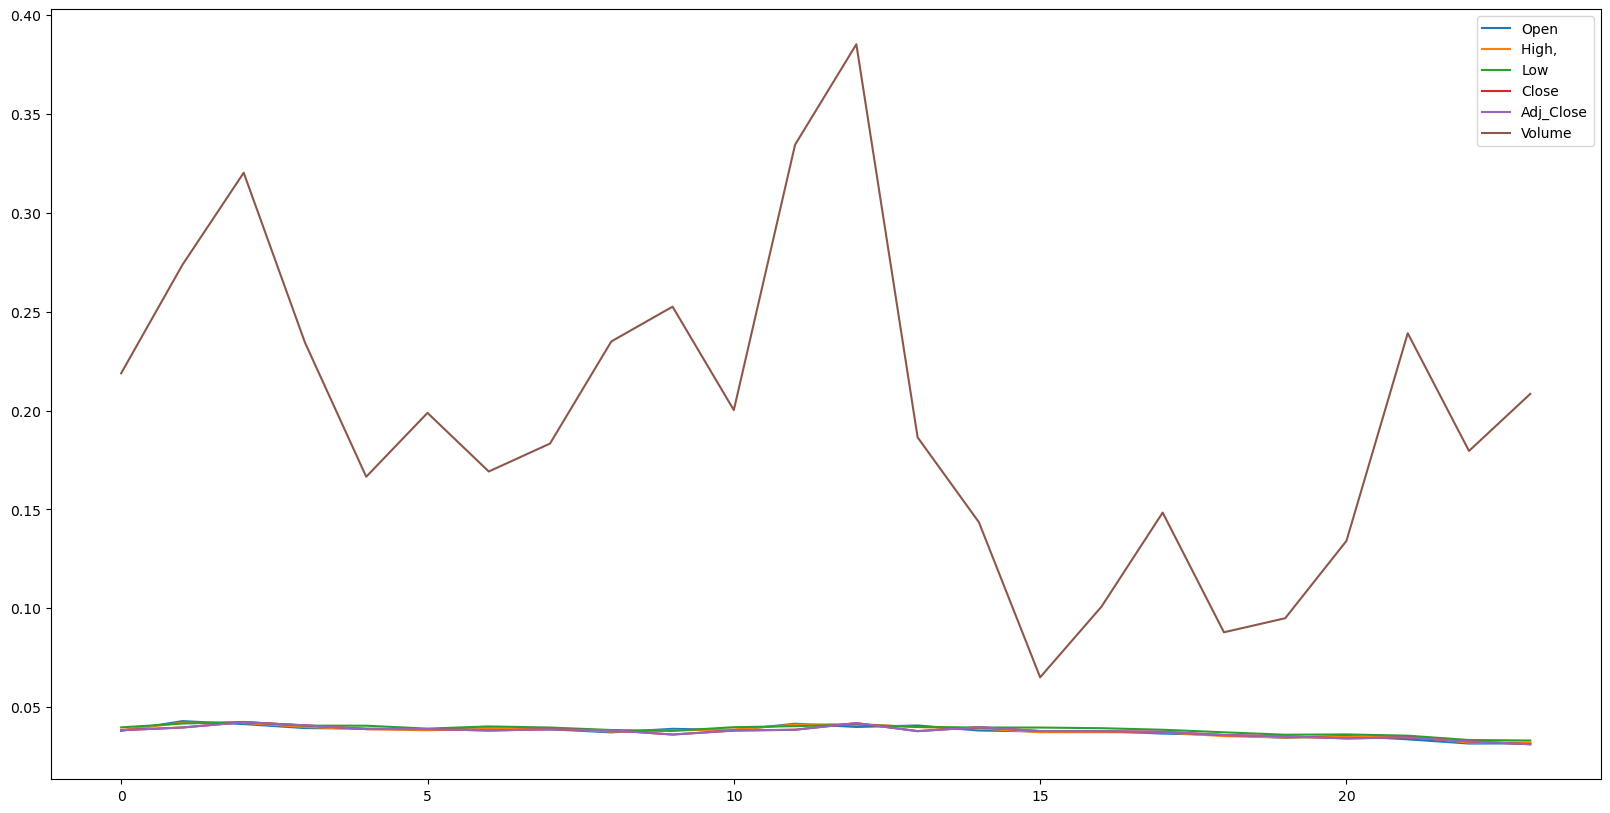

In [77]:
# Plot the data, those are stock data, with multiple columns that needs to be in chronological order, MAKE IT beautiful and clear with legend there is no date column
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(data[34])
plt.legend(['Open', 'High, ', 'Low', 'Close', 'Adj_Close', 'Volume'])
plt.show()

In [78]:
# Load the real data into a PyTorch DataLoader 
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

batch_size = 64

# Convert data to PyTorch tensors
data_tensor = torch.tensor(data)

# Create a RandomSampler to shuffle the data
sampler = RandomSampler(data_tensor)

# Create a DataLoader to batch the data and enable iteration
real_series = DataLoader(data_tensor, batch_size=batch_size)

# Create an iterator from the DataLoader
real_series_iter = iter(real_series)

# Show the first batch of real data
real_batch = next(real_series_iter)

# show me the dimension of the real batch
print(real_batch.shape)


In [80]:
batch_size = 64
# Create synthetic data
from torch.utils.data import DataLoader, IterableDataset

class RandomDataset(IterableDataset):
    def __init__(self, seq_len, n_seq):
        self.seq_len = seq_len
        self.n_seq = n_seq

    def __iter__(self):
        while True:
            yield torch.from_numpy(np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))).float()

# Create an instance of the dataset
dataset = RandomDataset(seq_len, n_seq)

# Create a DataLoader to batch the data and enable iteration
random_series = DataLoader(dataset, batch_size=batch_size)

# Create an iterator from the DataLoader
random_series_iter = iter(random_series)

## Network definition

In [81]:
# Network parameters

hidden_dim = 12
num_layers = 3

# Set up tensorboard X
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

### Embedder and recovery network 

In [82]:
class Embedder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Embedder, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x): # X is the real input sequence
        x, _ = self.lstm1(x)
        return x

In [83]:
# Recovery network
class Recovery(torch.nn.Module):
    def __init__(self, hidden_dim, seq_len):
        super(Recovery, self).__init__()
        self.lstm1 = nn.LSTM(hidden_dim, seq_len, num_layers=num_layers)

    def forward(self, x): # X is the real input sequence
        x, _ = self.lstm1(x)
        return x

### Generator & discriminator

In [84]:
# Generator network
class Generator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Generator, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers = num_layers)

    def forward(self, x): # X is the real input sequence
        x, _ = self.lstm1(x)
        return x

In [85]:
# Discriminator network
class Discriminator(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(Discriminator, self).__init__()
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x): # X is the real input sequence
        x, _ = self.lstm1(x)
        x = self.linear(x)
        return x

### Supervisor loss

In [86]:
class Supervisor(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(Supervisor, self).__init__()
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers-1)

    def forward(self, x): # X is the real input sequence
        x, _ = self.lstm1(x)
        return x

## Phase 1: Autoencoder training

In [93]:
import torch.nn as nn
train_steps = 200
gamma = 1
lr = 0.00005
stop_loss = 0.001
mse = nn.MSELoss()
bce = nn.BCELoss()

In [94]:
from tqdm import tqdm

H = Embedder(n_seq, hidden_dim)

R = Recovery(hidden_dim, n_seq)

autoencoder = nn.Sequential(H, R)
autoencoder_optimizer = torch.optim.Adam(list(H.parameters()) + list(R.parameters()), lr= lr)

# Autoencoder training loop
for epoch in tqdm(range(train_steps)):
    autoencoder.train()
    # for i in enumerate(real_series):
    #     real_batch = i[1]
    X_ = next(iter(real_series))
    X_ = X_.to(H.lstm1.weight_ih_l0.dtype)

    embedder_representation = H(X_)
    recovered_sequence = R(embedder_representation)
    
    loss = mse(X_, recovered_sequence)
    
    autoencoder_optimizer.zero_grad()
    loss.backward()
    autoencoder_optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        # put a stop to the training loop if the loss is less than 0.0001
        if loss.item() < stop_loss:
            break
    # Return the loss to tensorboard
    writer.add_scalar('Autoencoder Loss', loss.item(), epoch)
    # # Return the model
    # writer.add_graph(autoencoder, real_batch)

  2%|▏         | 4/200 [00:00<00:10, 18.48it/s]

Epoch 0, Loss 0.17339661717414856


  6%|▋         | 13/200 [00:00<00:08, 21.16it/s]

Epoch 10, Loss 0.17251789569854736


 12%|█▎        | 25/200 [00:01<00:08, 21.44it/s]

Epoch 20, Loss 0.17164646089076996


 17%|█▋        | 34/200 [00:01<00:07, 21.05it/s]

Epoch 30, Loss 0.1707829236984253


 22%|██▏       | 43/200 [00:02<00:07, 19.76it/s]

Epoch 40, Loss 0.16992752254009247


 28%|██▊       | 55/200 [00:02<00:06, 21.23it/s]

Epoch 50, Loss 0.16908025741577148


 32%|███▏      | 64/200 [00:03<00:06, 21.43it/s]

Epoch 60, Loss 0.16824102401733398


 36%|███▋      | 73/200 [00:03<00:05, 21.59it/s]

Epoch 70, Loss 0.16740942001342773


 42%|████▎     | 85/200 [00:04<00:05, 21.29it/s]

Epoch 80, Loss 0.16658522188663483


 47%|████▋     | 94/200 [00:04<00:04, 21.66it/s]

Epoch 90, Loss 0.1657680869102478


 52%|█████▏    | 103/200 [00:04<00:04, 21.74it/s]

Epoch 100, Loss 0.16495779156684875


 57%|█████▊    | 115/200 [00:05<00:04, 21.16it/s]

Epoch 110, Loss 0.16415399312973022


 62%|██████▏   | 124/200 [00:05<00:03, 21.07it/s]

Epoch 120, Loss 0.16335640847682953


 68%|██████▊   | 135/200 [00:06<00:03, 19.44it/s]

Epoch 130, Loss 0.16256484389305115


 72%|███████▏  | 144/200 [00:06<00:02, 20.86it/s]

Epoch 140, Loss 0.16177898645401


 76%|███████▋  | 153/200 [00:07<00:02, 20.78it/s]

Epoch 150, Loss 0.1609986126422882


 81%|████████  | 162/200 [00:07<00:01, 20.05it/s]

Epoch 160, Loss 0.16022339463233948


 88%|████████▊ | 175/200 [00:08<00:01, 18.64it/s]

Epoch 170, Loss 0.15945309400558472


 92%|█████████▏| 183/200 [00:08<00:00, 19.98it/s]

Epoch 180, Loss 0.15868741273880005


 98%|█████████▊| 195/200 [00:09<00:00, 20.76it/s]

Epoch 190, Loss 0.15792600810527802


100%|██████████| 200/200 [00:09<00:00, 20.50it/s]


## Phase 2: Supervisor training

In [95]:
# Supervisor 
S = Supervisor(hidden_dim)

# Define the optimizer for the Supervisor
supervisor_optimizer = torch.optim.Adam(list(S.parameters()), lr=lr)

In [97]:
# Train the supervisor network
for epoch in tqdm(range(train_steps)):
    S.train()
    X_ = next(iter(real_series))
    X_ = X_.to(H.lstm1.weight_ih_l0.dtype)
    
    h = H(X_)
    h_hat_supervisor = S(h)

    loss = mse(h[:, 1:, :], h_hat_supervisor[:, :-1, :])

    supervisor_optimizer.zero_grad()
    loss.backward()
    supervisor_optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        if loss.item() < stop_loss:
            break
    # Return the loss to tensorboard
    writer.add_scalar('Supervisor Loss', loss.item(), epoch)

  2%|▏         | 4/200 [00:00<00:11, 17.31it/s]

Epoch 0, Loss 0.014944842085242271


 28%|██▊       | 55/200 [00:02<00:05, 24.62it/s]

Epoch 50, Loss 0.013225260190665722


 53%|█████▎    | 106/200 [00:04<00:03, 24.97it/s]

Epoch 100, Loss 0.011595374904572964


 77%|███████▋  | 154/200 [00:06<00:01, 23.84it/s]

Epoch 150, Loss 0.010043097659945488


100%|██████████| 200/200 [00:08<00:00, 23.66it/s]


## Phase 3: Joint training

### Adversarial - Supervise

Here the supervisor is trained to make the generated sequence look more like the real sequence by incentivizing the generator to  make the supervisor representation look real and learn the temporal aspect. The supervisor is trained with the Embedder, where the embedder learns to map in the latent space the temporal aspect of the real sequence. The supervisor learns to minimize the generated latent sequence from the embedder and his "refined" sequence to be as close as possible. And so, having learn the temporal aspect of the latent real sequence, the supervisor learns the temporal aspect. Then, he can supervise the generator to make the generated sequence look more like the real sequence by recontruscting the sequence of the generator in his way, then pass it to the discriminator and classify it as real or fake, then optimize.  

In short, the supervisor learns from the embedding space of the real sequence to learn the temporal aspect. 
Then, goes on to supervisor the generator by adversarily training with it and the discriminator, so has to force the generator to generate sequence that the supervisor will aim at encode further and fool the discriminator. This can make the generator learn better because, the supervisor learned previously to minimize the loss between the latent representation of the real sequence and the latent representation of the supervisor of the real sequence itself. Thus, the supervisor learn the temporal dynamics, which in turn can guide the generator to minimize loss by making the generator generating sequence that possess closer temporal dynamics. 

In [98]:
# Architecture adversarial training
G = Generator(n_seq, hidden_dim)
D = Discriminator(hidden_dim)

adversarial_supervised = nn.Sequential(G, S, D)

### Adversarial in latent space

In [99]:
adversarial_network = nn.Sequential(G, D)

### Mean & Variance Loss

From the generator random vector output in the latent space, the Recovery takes it and reconstruct the sequence. 

The recovery should be good at reconstructing as it was trained to reconstruct latent real sequence back to original sequence. 

In [100]:
synthetic_data = nn.Sequential(G, R)

In [101]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean = y_true.mean(dim=0)
    y_true_var = y_true.var(dim=0, unbiased=False)
    y_pred_mean = y_pred.mean(dim=0)
    y_pred_var = y_pred.var(dim=0, unbiased=False)
    g_loss_mean = (y_true_mean - y_pred_mean).abs().mean()
    g_loss_var = (y_true_var.sqrt() - y_pred_var.sqrt()).abs().mean()
    return g_loss_mean + g_loss_var

### Discriminator - Real data

This is the classic reconstruction loss

In [102]:
discriminator_real = nn.Sequential(H, D)

## Training 

Now we need to train the network. 
1. Essentialy, the generator as to learn how to generate proper sequence, this through the adversarial supervise training 
2. The generator also has to learn how to feel the discriminator 
3. The generator also has to learn how to generate proper synthetic data using the recovery system. So I believe that after doing the first two part of the training, we can focus on the 3rd part, assuming that the autoencoder training between the embedder and Recovery part was well perform.  

In [ ]:
# Define the optimizer for the Generator
generator_optimizer = torch.optim.Adam(list(G.parameters()) + list(S.parameters()), lr=lr)

# Embedding optimizer 
embedding_optimizer = torch.optim.Adam(list(H.parameters()) + list(R.parameters()), lr=lr)

# Define the optimizer for the Discriminator

discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

#### 1. Generator train step

In [105]:
import torch.nn.functional as F
def train_generator(X, Z):
    G.train()
    S.train()
    
    y_fake_e = adversarial_network(Z)
    generator_loss_unsupervised =  F.binary_cross_entropy_with_logits(y_fake_e, torch.ones_like(y_fake_e))
    
    y_fake = adversarial_supervised(Z)
    generator_loss_unsupervised_e =  F.binary_cross_entropy_with_logits(y_fake, torch.ones_like(y_fake))
    
    X = X.to(H.lstm1.weight_ih_l0.dtype)
    
    h = H(X)
    h_hat_supervised = S(h)
    generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_hat = synthetic_data(Z)
    generator_moment_loss = get_generator_moment_loss(X, x_hat)
    
    # Loss for the generator
    generator_loss = (generator_loss_unsupervised +
                      generator_loss_unsupervised_e +
                      100 * torch.sqrt(generator_loss_supervised) +
                      100 * generator_moment_loss)
    generator_loss.backward()
    generator_optimizer.step()
    
    generator_optimizer.zero_grad()

    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

#### 2. Embedder train step
The embedder is trained jointly with the supervisor, by minimizing two loss function. 
1. The loss of the renconstruction of the supervisor from the latent representation of the real sequence (Called Generator loss supervised)
2. The loss of the Recovey (General reconstruction loss of the autoencoder)

In [106]:
def train_embedder(x):
    # Ensure the model is in training mode
    H.train()
    R.train()

    # Forward pass
    x = x.to(H.lstm1.weight_ih_l0.dtype)
    h = H(x)
    h_hat_supervised = S(h)
    generator_loss_supervised = F.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_tilde = autoencoder(x)
    embedding_loss_t0 = F.mse_loss(x, x_tilde)
    e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    # Backward pass and optimization
    e_loss.backward()
    embedding_optimizer.step()

    # Zero the gradients
    embedding_optimizer.zero_grad()

    return torch.sqrt(embedding_loss_t0)

#### 3. Discriminator train step
1. There is the real discriminator loss (y_real)  
2. The adversarial supervised loss (y_supervised)
3. The adversarial network loss (y_fake)

In [107]:
def get_discriminator_loss(x, z):
    #D.train()
 
    x = x.to(H.lstm1.weight_ih_l0.dtype) 

    # Forward pass
    y_real = discriminator_real(x)
    discriminator_loss_real = F.binary_cross_entropy_with_logits(y_real, torch.ones_like(y_real))

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = F.binary_cross_entropy_with_logits(y_fake, torch.zeros_like(y_fake))

    y_fake_e = adversarial_network(z)
    discriminator_loss_fake_e = F.binary_cross_entropy_with_logits(y_fake_e, torch.zeros_like(y_fake_e))

    return discriminator_loss_real + discriminator_loss_fake + gamma * discriminator_loss_fake_e

In [109]:
def train_discriminator(x, z):
    # Ensure the model is in training mode
    D.train()

    # Forward pass
    discriminator_loss = get_discriminator_loss(x, z)

    # Backward pass and optimization
    discriminator_loss.backward()
    discriminator_optimizer.step()

    # Zero the gradients
    discriminator_optimizer.zero_grad()

    return discriminator_loss

### Training Loop

In [110]:
from torch.utils.tensorboard import SummaryWriter

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
writer = SummaryWriter()

for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(iter(real_series))  # Assuming real_series returns (data, target)
        Z_ = next(iter(random_series))  # Assuming random_series returns (data, target)
        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)
    
    X_ = next(iter(real_series))  # Assuming real_series returns (data, target)
    Z_ = next(iter(random_series))  # Assuming random_series returns (data, target)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)
            
    if step % 10 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
            f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')
        if step_g_loss_u.item() < stop_loss:
                break

    writer.add_scalar('G Loss S', step_g_loss_s.item(), step)
    writer.add_scalar('G Loss U', step_g_loss_u.item(), step)
    writer.add_scalar('G Loss V', step_g_loss_v.item(), step)
    writer.add_scalar('E Loss T0', step_e_loss_t0.item(), step)
    writer.add_scalar('D Loss', step_d_loss.item(), step)


     0 | d_loss: 2.3070 | g_loss_u: 0.5297 | g_loss_s: 0.0085 | g_loss_v: 0.5004 | e_loss_t0: 0.3964
    10 | d_loss: 2.3103 | g_loss_u: 0.5279 | g_loss_s: 0.0075 | g_loss_v: 0.4982 | e_loss_t0: 0.3946
    20 | d_loss: 2.3137 | g_loss_u: 0.5261 | g_loss_s: 0.0066 | g_loss_v: 0.4961 | e_loss_t0: 0.3929
    30 | d_loss: 2.3171 | g_loss_u: 0.5242 | g_loss_s: 0.0057 | g_loss_v: 0.4939 | e_loss_t0: 0.3912
    40 | d_loss: 2.3206 | g_loss_u: 0.5224 | g_loss_s: 0.0049 | g_loss_v: 0.4918 | e_loss_t0: 0.3896
    50 | d_loss: 2.3242 | g_loss_u: 0.5205 | g_loss_s: 0.0042 | g_loss_v: 0.4896 | e_loss_t0: 0.3880
    60 | d_loss: 2.3278 | g_loss_u: 0.5186 | g_loss_s: 0.0035 | g_loss_v: 0.4875 | e_loss_t0: 0.3864
    70 | d_loss: 2.3315 | g_loss_u: 0.5166 | g_loss_s: 0.0029 | g_loss_v: 0.4853 | e_loss_t0: 0.3849
    80 | d_loss: 2.3353 | g_loss_u: 0.5146 | g_loss_s: 0.0023 | g_loss_v: 0.4831 | e_loss_t0: 0.3833
    90 | d_loss: 2.3392 | g_loss_u: 0.5126 | g_loss_s: 0.0018 | g_loss_v: 0.4809 | e_loss_t

### Save the Syntetic Data generator 

In [ ]:
# # What log_dir should I put?
# log_dir = '/Users/philippebeliveau/Desktop/Notebook/GAN/Generated_Data:Synthetizer/V1'
# synthetic_data.save(log_dir / 'synthetic_data')

## Generate synthetic data

In [111]:
n_windows = 3686
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series_iter)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [113]:
generated_data = [tensor.detach().numpy() for tensor in generated_data]
generated_data = np.vstack(generated_data)
generated_data.shape

(3648, 24, 6)

### Rescale

In [114]:
def MinMaxScaler(data):
    """Min-Max Normalizer.

    Args:
        - data: raw data
        
    Returns:
        - norm_data: normalized data
        - min_val: minimum values (for renormalization)
        - max_val: maximum values (for renormalization)
    """    
    min_val = np.min(np.min(data, axis = 0), axis = 0)
    data = data - min_val
        
    max_val = np.max(np.max(data, axis = 0), axis = 0)
    norm_data = data / (max_val + 1e-7)
        
    return norm_data, min_val, max_val

# Normalization
d1, min_val, max_val = MinMaxScaler(data)

In [115]:
# Renormalization
generated_data = generated_data * max_val
generated_data = generated_data + min_val

In [116]:
# # Persist data
# with pd.HDFStore(hdf_store) as store:
#     store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq)))

## Evaluation


[See notebook](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/21_gans_for_synthetic_time_series/03_evaluating_synthetic_data.ipynb)

Evaluating the quality of synthetic time-series data
The TimeGAN authors assess the quality of the generated data with respect to three practical criteria:

Diversity: the distribution of the synthetic samples should roughly match that of the real data
Fidelity: the sample series should be indistinguishable from the real data, and
Usefulness: the synthetic data should be as useful as their real counterparts for solving a predictive task
The authors apply three methods to evaluate whether the synthetic data actually exhibits these characteristics:

Visualization: for a qualitative diversity assessment of diversity, we use dimensionality reduction (principal components analysis (PCA) and t-SNE, see Chapter 13) to visually inspect how closely the distribution of the synthetic samples resembles that of the original data
Discriminative Score: for a quantitative assessment of fidelity, the test error of a time-series classifier such as a 2-layer LSTM (see Chapter 18) let’s us evaluate whether real and synthetic time series can be differentiated or are, in fact, indistinguishable.
Predictive Score: for a quantitative measure of usefulness, we can compare the test errors of a sequence prediction model trained on, alternatively, real or synthetic data to predict the next time step for the real data.

### Plot sample time series

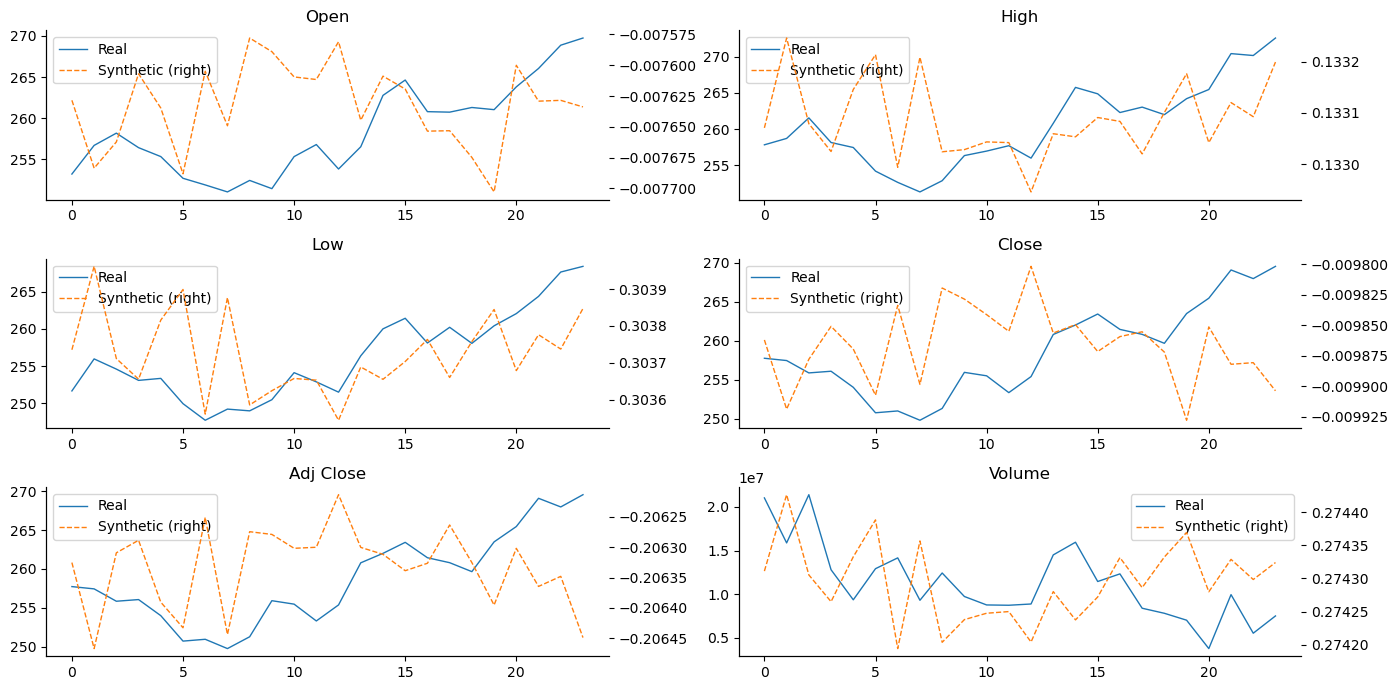

In [119]:
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
idx = np.random.randint(len(df))

tickers = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': df.iloc[idx: idx + seq_len].iloc[:, j].values,
                   'Synthetic': generated_data[idx][:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()